In [176]:
import os
from pathlib import Path

import numpy as np
import torch
from matplotlib import pyplot as plt

from PIL import Image

In [2]:
dataset_directory = "dataset"


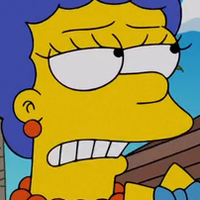

In [3]:
img = Image.open(Path() / "../../stylegan/simpsons/cropped" / "17.png")
img

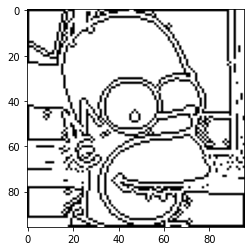

In [149]:
import cv2


def find_edges(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # img = cv2.imread(str(Path() / "small_data/sprites_rgb" / file_name), cv2.IMREAD_GRAYSCALE)
    ret, thresh = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)
    # img_gray = cv2.cvtColor(np.array(img)[:, :, ::-1], cv2.COLOR_BGR2GRAY)

    contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    # draw contours on the original image
    image_copy = np.ones_like(img) * 255
    cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 0, 0), thickness=1,)
    return image_copy


for file_name in os.listdir("small_data/sprites_rgb"):
    # img = Image.open(Path() / "small_data/sprites_rgb" / file_name).convert('RGB')

    img = cv2.imread(str(Path() / "small_data/sprites_rgb" / file_name))

    image_copy = find_edges(img)

    plt.imshow(image_copy, cmap="gray")
    plt.show()
    break

(96, 96, 3)


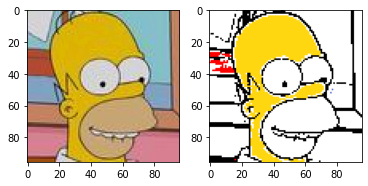

In [354]:
import cv2
from matplotlib.colors import hsv_to_rgb


def simplify(img):
    print(img.shape)
    black_pixels = np.where(
        # (img[:, :, 0] < black_threshold) &
        (img[:, :, 2] < 160)
        # (img[:, :, 2] < black_threshold)
        # (abs(as_array[:, :, 0] - as_array[:, :, 1]) < 10) &
    )

    yellow_pixels = np.where(
        (img[:, :, 0] > 20) & (img[:, :, 0] < 30) &
        (img[:, :, 1] > 200) & (img[:, :, 1] < 300)
    )

    blue_pixels = np.where(
        (img[:, :, 0] > 110) & (img[:, :, 0] < 130) &
        (img[:, :, 1] > 100)  #& (img[:, :, 1] < 300)
    )

    red_pixels = np.where(
        (img[:, :, 0] > 0) & (img[:, :, 0] < 15) &
        (img[:, :, 1] > 180)  #& (img[:, :, 1] < 300)
        & (img[:, :, 2] > 100)
    )

    blank = np.ones_like(img) * 255
    blank[yellow_pixels] = [254, 215, 16]
    blank[blue_pixels] = [99, 111, 221]
    blank[red_pixels] = [255, 0, 0]
    blank[black_pixels] = 0

    # edges = find_edges(img)
    # blank[edges == 0] = 0

    # blank = cv2.fastNlMeansDenoisingColored(blank, None, 20)

    black_pixels = np.zeros_like(img)
    black_pixels[np.where((blank[:,:,0] == 0) & (blank[:,:,1] == 0) & (blank[:,:,2] == 0))] = 1
    black_pixels = black_pixels[None, :, :, 0]

    yellow_pixels = np.zeros_like(img)
    yellow_pixels[np.where((blank[:,:,0] == 254) & (blank[:,:,1] == 215) & (blank[:,:,2] == 16))] = 1
    yellow_pixels = yellow_pixels[None, :, :, 0]

    blue_pixels = np.zeros_like(img)
    blue_pixels[np.where((blank[:,:,0] == 99) & (blank[:,:,1] == 111) & (blank[:,:,2] == 221))] = 1
    blue_pixels = blue_pixels[None, :, :, 0]

    red_pixels = np.zeros_like(img)
    red_pixels[np.where((blank[:,:,0] == 255) & (blank[:,:,1] == 0) & (blank[:,:,2] == 0))] = 1
    # red_pixels = np.moveaxis(red_pixels, 2, 0)
    red_pixels = red_pixels[None, :, :, 0]

    pixels = np.concatenate([black_pixels, yellow_pixels, blue_pixels, red_pixels])
    pixels = torch.Tensor(pixels)

    return blank, pixels


for i, file_name in enumerate(os.listdir("data_cleared/sprites_rgb")):
    img = cv2.imread(str(Path() / "data_cleared/sprites_rgb" / file_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # thresh =

    blank, pixels = simplify(img)

    Image.fromarray(blank.astype(np.uint8)).show()
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_HSV2RGB))
    ax2.imshow(blank)
    plt.show()

    if i == 0:
        break

In [337]:
red_pixels.sum()
# np.where((blank[:,:,0] == 255) & (blank[:,:,1] == 0) & (blank[:,:,2] == 0))

96

In [334]:
red_pixels = np.zeros_like(img)
red_pixels[np.where((blank[:,:,0] == 255) & (blank[:,:,1] == 0) & (blank[:,:,2] == 0))] = 1
# red_pixels = np.moveaxis(red_pixels, 2, 0)
red_pixels = red_pixels[None, :, :, 0]
red_pixels.sum()
# test = (blank == 255)#, (blank[:,:,1] == 0), (blank[:,:,2] == 0)
# test.any()
# blank.max()

96

tensor(96.)

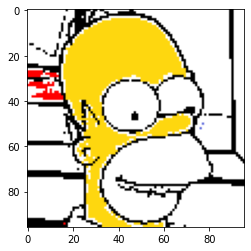

In [352]:
# def restore_simplified(x):
black, yellow, blue, red = torch.split(pixels, [1, 1, 1, 1], dim=0)

def color(t, r, g, b):
    return torch.cat([t * (1 - r), t * (1 - g), t * (1 - b)], dim=0)

white = color(torch.ones_like(black), 0, 0, 0)

img = white - \
       color(red, 255 / 255, 0, 0) - \
       color(black, 0, 0, 0) - \
       color(blue, 99 / 255, 111 / 255, 221 / 255) - \
       color(yellow, 254 / 255, 215 / 255, 16 / 255) \

img = img.numpy().transpose((1, 2, 0)) * 255
img = img.astype(np.uint8)
# test_ims_show = np.array(test_ims_show * 255, dtype=np.uint8)
# image = Image.fromarray(test_ims_show)
plt.imshow(img)
red.sum()

In [83]:
img[0, :, 0]

array([ 34,  34,  34,  34,  34,  34,  34,  34,  34,  34,  34,  34,  34,
        34,  34,  37,  40,  41,  39,  40,  39,  35,  21,  26,  27,  29,
        32,  34,  33,  36,  37,  37,  28,  26,  21,  24, 126, 125, 124,
       120,  19,  27,  27,  27,  27,  25,  27,  26,  25,  23,  24,  24,
        24,  24,  24,  25,  23,  23,  19,  14,  13,  21,  21,  19,  15,
        12,  13,  23,  35,  90, 112, 106,  69,  48,  45,  43, 130, 133,
       159,   5,  30,  38,  38,  38,  38,  37,  37,  37,  39,  38,  43,
        50, 110, 115, 120, 120], dtype=uint8)

In [22]:
img.thumbnail([96, 96], Image.ANTIALIAS)
img = img.convert("RGBA")
new_image = Image.new("RGBA", img.size, "WHITE")
new_image.paste(img, (0, 0), img)
new_image.convert('RGB')
# img.convert("RGB", img.size, (255,255,255))

AttributeError: 'numpy.ndarray' object has no attribute 'thumbnail'

In [345]:
in_dir = Path() / "data_cleared/sprites_rgb/" # "../homers_dataset"  # Path() / "../../stylegan/simpsons/cropped"
out_dir = Path() / "data_cleared_simplified"

def png_to_jpg(file_name):
    name, ext = os.path.splitext(file_name)
    img = Image.open(in_dir / file_name).convert("RGBA")
    new_image = Image.new("RGBA", img.size, "WHITE")
    new_image.paste(img, (0, 0), img)
    img = new_image.convert('RGB')
    # img = img.convert("RGB")
    img.thumbnail([96, 96], Image.ANTIALIAS)
    img.save(out_dir / "sprites_rgb" / (name + ".jpg"))

def simplify_jpg(file_name):
    name, ext = os.path.splitext(file_name)
    img = cv2.imread(str(in_dir / file_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    simplified, pixels = simplify(img)
    simplified = Image.fromarray(simplified)
    simplified.save(out_dir / "sprites_rgb" / (name + ".jpg"))

for file_name in os.listdir(in_dir):
    try:
        # png_to_jpg(file_name)
        simplify_jpg(file_name)
    except ValueError:
        print(file_name)
        pass

In [24]:
from IPython.display import display
from IPython.display import clear_output
import ipywidgets as widgets

button = widgets.Button(description="a Me!")
button1 = widgets.Button(description="b Me!")
output = widgets.Output()

display(button, button1, output)


def on_button_clicked(b):
    with output:
        print("Button clicked.")


button.on_click(on_button_clicked)

Button(description='a Me!', style=ButtonStyle())

Button(description='b Me!', style=ButtonStyle())

Output()

In [25]:
test = 1


def f():
    global test
    test = test + 1


f()
test

2

Button(description='Save', style=ButtonStyle())

Button(description='Delete', style=ButtonStyle())

Output(outputs=({'output_type': 'stream', 'text': '72.jpg\n', 'name': 'stdout'},))

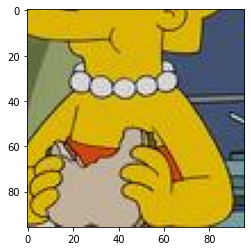

In [28]:
# I stopped on 2004
bad_images = []
path = Path() / ".." / "simpsons_dataset"
file_names = os.listdir(path)
file_names.sort(key=lambda fname: int(fname.split(".")[0]))
start_from = -1
index, file_name = start_from, "a"


def get_next_image():
    global index, file_name, image
    index, file_name = index + 1, file_names[index + 1]
    name, ext = os.path.splitext(file_name)
    img = Image.open(path / file_name).convert("RGBA")
    clear_output(wait=True)
    output.clear_output()

    plt.imshow(img)
    display(save_button, delete_button, output)
    with output:
        print(file_name)

    return img


save_button = widgets.Button(description="Save")
delete_button = widgets.Button(description="Delete")
output = widgets.Output()

img = get_next_image()


# display(save_button, delete_button, output)

def on_save_button_clicked(b):
    global img, file_name

    with output:
        print(f"Image {file_name} saved")

    img = Image.open(path / file_name).convert("RGBA")
    new_image = Image.new("RGBA", img.size, "WHITE")
    new_image.paste(img, (0, 0), img)
    img = new_image.convert('RGB')
    # img = img.convert("RGB")
    img.thumbnail([96, 96], Image.ANTIALIAS)
    img.save(Path() / ".." / "simpsons_cleared" / file_name)

    os.remove(path / file_name)
    get_next_image()


def on_delete_button_clicked(b):
    global img, file_name

    with output:
        print(f"Image {file_name} deleted")

    os.remove(path / file_name)
    get_next_image()


save_button.on_click(on_save_button_clicked)
delete_button.on_click(on_delete_button_clicked)

In [ ]:
dir(output)